# Comparing methods to simulate radial Ornstein-Uhlenbeck bridge 
This is a specific case of an interest rates model proposed by Aït-Sahalia and Lo (Journal of Finance, 1998)

In [1]:
import DiffusionBridge as db
import torch
import matplotlib.pyplot as plt
from scipy.special import iv, ivp
from torch.distributions.gamma import Gamma
plt.style.use('ggplot')

In [2]:
# problem settings
d = 1
theta = torch.tensor(4.0)
f = lambda t,x: theta / x - x 
sigma = torch.tensor(1.0)
T = torch.tensor(1.0)
M = 50
diffusion = db.diffusion.model(f, sigma, d, T, M)

# transition density
log_transition_density = lambda t,x,x0: theta * torch.log(x / x0) + 0.5 * torch.log(x * x0) - x**2 \
                                    + (theta + 0.5) * t - torch.log(torch.sinh(t)) \
                                    - (x**2 + x0**2) / (torch.exp(2.0 * t) - 1.0) \
                                    + torch.log(iv(theta - 0.5, x * x0 / torch.sinh(t)))

score_transition = lambda t,x,x0: theta / x + 1.0 / (2.0 * x) - 2.0 * x - 2.0 * x / (torch.exp(2.0 * t) - 1.0) \
                                 + (1.0 / iv(theta - 0.5, x * x0 / torch.sinh(t))) * ivp(theta - 0.5, x * x0 / torch.sinh(t)) * x0 / torch.sinh(t)

# h-transform
grad_logh = lambda t,x,xT: -theta / x + 1.0 / (2.0 * x) - 2.0 * x / (torch.exp(2.0 * (T-t)) - 1.0) \
                        + (1.0 / iv(theta - 0.5, xT * x / torch.sinh(T-t))) * ivp(theta - 0.5, xT * x / torch.sinh(T-t)) * xT / torch.sinh(T-t)

# score marginal 
score_marginal = lambda t,x,x0,xT: score_transition(t, x, x0) + grad_logh(t, x, xT)

# repetitions
N = 2**10
R = 100


In [3]:
# initial and terminal conditions
initial_condition = [1.5, 1.5, 3.0]
terminal_condition = [1.0, 2.5, 5.0]

In [4]:
# learn backward diffusion bridge process with score matching
distribution_X0 = Gamma(torch.tensor(5.0), torch.tensor(2.0))
simulate_X0 = lambda n: distribution_X0.sample((n, )).reshape(n, d)
XT = []
epsilon = 1e-3
minibatch = 100
num_initial_per_batch = 10
num_iterations = 1000
learning_rate = 0.01
ema_momentum = 0.99

output = diffusion.learn_full_score_transition(simulate_X0, XT, epsilon, minibatch, num_initial_per_batch, num_iterations, learning_rate, ema_momentum)
score_transition_net = output['net']
loss_values_transition = output['loss']

Optimization iteration: 1 Loss: 49.85770034790039
Optimization iteration: 50 Loss: 45.38977813720703
Optimization iteration: 100 Loss: 42.93485641479492
Optimization iteration: 150 Loss: 42.869781494140625
Optimization iteration: 200 Loss: 43.43869400024414
Optimization iteration: 250 Loss: 42.70743942260742
Optimization iteration: 300 Loss: 43.25973129272461
Optimization iteration: 350 Loss: 43.44459915161133
Optimization iteration: 400 Loss: 43.041866302490234
Optimization iteration: 450 Loss: 43.80331039428711
Optimization iteration: 500 Loss: 42.17720031738281
Optimization iteration: 550 Loss: 43.09767150878906
Optimization iteration: 600 Loss: 42.927581787109375
Optimization iteration: 650 Loss: 42.85287094116211
Optimization iteration: 700 Loss: 43.434688568115234
Optimization iteration: 750 Loss: 42.5477294921875
Optimization iteration: 800 Loss: 42.61547088623047
Optimization iteration: 850 Loss: 43.227481842041016
Optimization iteration: 900 Loss: 43.34138107299805
Optimizatio

In [30]:
score_transition_net

FullScoreNetwork(
  (net): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=1, bias=True)
    )
    (activation_fn): LeakyReLU(negative_slope=0.01)
  )
  (t_encoder): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Linear(in_features=16, out_features=32, bias=True)
    )
    (activation_fn): LeakyReLU(negative_slope=0.01)
  )
  (x_encoder): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=16, bias=True)
      (1): Linear(in_features=16, out_features=32, bias=True)
    )
    (activation_fn): LeakyReLU(negative_slope=0.01)
  )
)

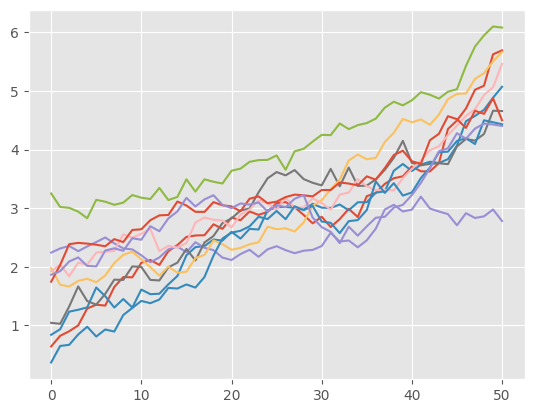

In [5]:
for i in range(10):
    output = diffusion.simulate_bridge_backwards(score_transition_net, simulate_X0(1)[0], torch.randn(1)+5, epsilon, N, modify = True, full_score = True)
    trajectories = output['trajectories']
    log_proposal = output['logdensity']
    plt.plot(trajectories.detach().numpy()[0], label='X')
plt.show()

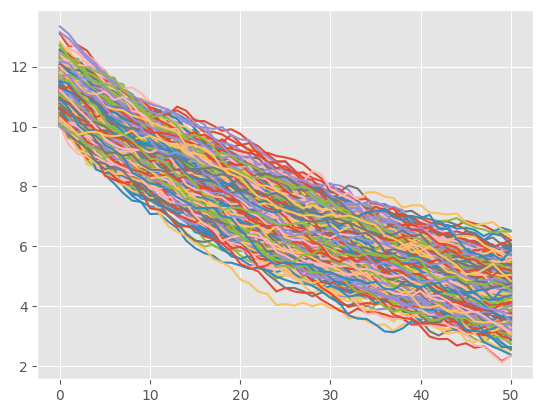

In [29]:
output = diffusion.simulate_process(10+torch.abs(torch.randn(1000,d)))
trajectories = output['trajectories']
plt.plot(*trajectories.detach().numpy().T, label='X')
plt.show()

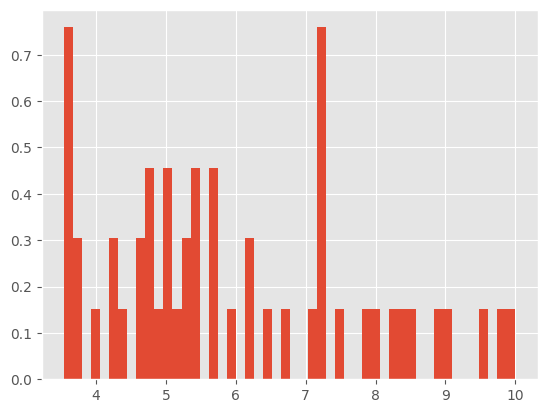

In [26]:
plt.hist(trajectories[-1].detach().numpy(), bins=50, density=True, label='X')
plt.show()

In [ ]:
# simulate modified backward diffusion bridge (MBDB) process with approximate score
MBDB = {'ess' : torch.zeros(3,R), 'logestimate' : torch.zeros(3,R), 'acceptrate' : torch.zeros(3,R)}

for c in range(3):
    X0 = initial_condition[c] * torch.ones(d)
    XT = terminal_condition[c] * torch.ones(d)

    for r in range(R):
        with torch.no_grad():
            output = diffusion.simulate_bridge_backwards(score_transition_net, X0, XT, epsilon, N, modify = True, full_score = True)
            trajectories = output['trajectories']
            log_proposal = output['logdensity']
        log_target = diffusion.law_bridge(trajectories)
        log_weights = log_target - log_proposal

        # importance sampling 
        max_log_weights = torch.max(log_weights)
        weights = torch.exp(log_weights - max_log_weights)
        norm_weights = weights / torch.sum(weights)
        ess = 1.0 / torch.sum(norm_weights**2)
        log_transition_estimate = torch.log(torch.mean(weights)) + max_log_weights
        MBDB['ess'][c,r] = ess
        MBDB['logestimate'][c,r] = log_transition_estimate

        # independent Metropolis-Hastings
        initial = diffusion.simulate_bridge_backwards(score_transition_net, X0, XT, epsilon, 1, modify = True, full_score = True)
        current_trajectory = initial['trajectories']
        current_log_proposal = initial['logdensity'] 
        current_log_target = diffusion.law_bridge(current_trajectory)
        current_log_weight = current_log_target - current_log_proposal
        num_accept = 0
        for n in range(N):
            proposed_trajectory = trajectories[n, :, :]
            proposed_log_weight = log_weights[n]
            log_accept_prob = proposed_log_weight - current_log_weight

            if (torch.log(torch.rand(1)) < log_accept_prob):
                current_trajectory = proposed_trajectory.clone()
                current_log_weight = proposed_log_weight.clone()  
                num_accept += 1
        accept_rate = num_accept / N
        MBDB['acceptrate'][c,r] = accept_rate
        
        # print
        print('Initial: ' + str(initial_condition[c]) + 
            ' Terminal: ' + str(terminal_condition[c]) + 
            ' Repeat: ' + str(r) + 
            ' ESS%: ' + str(float(ess * 100 / N)) + 
            ' log-transition density: ' + str(float(log_transition_estimate)), 
            ' Accept rate: ' + str(float(accept_rate)))


In [ ]:
# compare ESS
for c in range(3):
    print('Initial: ' + str(initial_condition[c]) + ' Terminal: ' + str(terminal_condition[c])) 
    print('FD ESS%: ' + str(float(torch.mean(FD['ess'][c,:]) * 100 / N)))
    print('MDB ESS%: ' + str(float(torch.mean(MDB['ess'][c,:]) * 100 / N)))
    print('CDH ESS%: ' + str(float(torch.mean(CDH['ess'][c,:]) * 100 / N)))
    print('MBDB ESS%: ' + str(float(torch.mean(MBDB['ess'][c,:]) * 100 / N)))


In [ ]:
# compare RMSE of log-transition density 
for c in range(3):
    X0 = initial_condition[c] * torch.ones(d)
    XT = terminal_condition[c] * torch.ones(d)
    print('Initial: ' + str(initial_condition[c]) + ' Terminal: ' + str(terminal_condition[c])) 
    print('FD RMSE: ' + str(float(torch.sqrt(torch.mean((FD['logestimate'][c,:] - log_transition_density(T, XT, X0))**2)))))
    print('MDB RMSE: ' + str(float(torch.sqrt(torch.mean((MDB['logestimate'][c,:] - log_transition_density(T, XT, X0))**2)))))
    print('CDH RMSE: ' + str(float(torch.sqrt(torch.mean((CDH['logestimate'][c,:] - log_transition_density(T, XT, X0))**2)))))
    print('MBDB RMSE: ' + str(float(torch.sqrt(torch.mean((MBDB['logestimate'][c,:] - log_transition_density(T, XT, X0))**2)))))

In [ ]:
# compare indepedent Meteropolis-Hastings acceptance rate
for c in range(3):
    print('Initial: ' + str(initial_condition[c]) + ' Terminal: ' + str(terminal_condition[c])) 
    print('FD acceptance%: ' + str(float(torch.mean(FD['acceptrate'][c,:] * 100))))
    print('MDB acceptance%: ' + str(float(torch.mean(MDB['acceptrate'][c,:] * 100))))
    print('CDH acceptance%: ' + str(float(torch.mean(CDH['acceptrate'][c,:] * 100))))
    print('MBDB acceptance%: ' + str(float(torch.mean(MBDB['acceptrate'][c,:] * 100))))


In [ ]:
# store results
results = {'FD': FD, 
           'MDB': MDB, 
           'CDH': CDH, 
           'MBDB': MBDB}

torch.save(results, 'radial_T1.pt')